<a href="https://colab.research.google.com/github/sidharthsinha/Retinal-OCT-Classifier/blob/main/OCT_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/kermany2018
! unzip kermany2018.zip

In [3]:
import torch.nn.functional as F

def accuracy(outputs, labels):
    max_probs, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class imageclassification(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss':loss, 'val_acc':acc}
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
class octnnmodel(imageclassification):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
  def forward(self, xb):
    return self.network(xb)
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [4]:
model = octnnmodel()
path = F"/content/drive/MyDrive/classifier.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [12]:
image_path = "/content/OCT2017 /"
import torchvision
import torchvision.transforms as transforms
import os
mean = [0.224, 0.224, 0.224]
std = [0.1551, 0.1551, 0.1551]

input_size = 32

batch_size = 16
num_epochs = 10

train_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((input_size, input_size)),
      transforms.Normalize((mean), (std))                              
])

val_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((input_size, input_size)),
      transforms.Normalize((mean), (std))
])

test_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((input_size, input_size)),
      transforms.Normalize((mean), (std))
])

train_ds = torchvision.datasets.ImageFolder(os.path.join(image_path, 'train'), train_transform)
val_ds = torchvision.datasets.ImageFolder(os.path.join(image_path, 'val'), val_transform)
test_ds = torchvision.datasets.ImageFolder(os.path.join(image_path, 'test'), test_transform)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


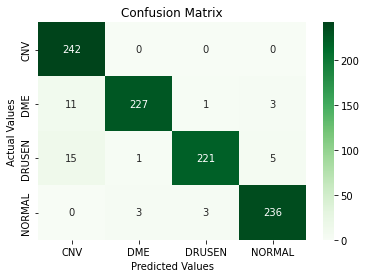

Accuracy :tensor(0.9577)
Precision[0.90298507 0.98268398 0.98222222 0.96721311]
Recall[1.         0.93801653 0.91322314 0.97520661]


In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
test_dl = torch.utils.data.DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)
acc = []
import numpy as np
p = []
l = []
for batch in test_dl:
  images, labels = batch
  for x in labels:
    l.append(int(x))
  output =  model(images)
  max_probs, preds = torch.max(output, dim=1)
  accu = accuracy(output, labels)
  acc.append(accu)
  for x in preds:
    p.append(int(x))
import seaborn as sns
cm = confusion_matrix(l, p)
import matplotlib.pyplot as plt
plt.title('Confusion Matrix')
sns.heatmap(cm, 
    annot=True, 
    xticklabels=["CNV", "DME", "DRUSEN", "NORMAL"], 
    yticklabels=["CNV", "DME", "DRUSEN", "NORMAL"],
    cmap='Greens', 
    fmt='g'
)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
print( "Accuracy :"+str( sum(acc)/len(acc) ) )
print("Precision"+str(precision_score(l, p, average=None)))
print("Recall"+str(recall_score(l, p, average=None)))
